# Visualization of Deep Network for Car Damage Localization.


Now that the network has been trained, we can visualize its attention. This allows to check if no overfitting occurs and to localize the damages region in the image. For this purpose, we will compute the class activation maps for the test images we feed to the network.

Basically, we will use the last feature maps and aggregate them with weights proportional to the gradient. Each weight $\alpha_k^c$ is the average of the gradients from each pixel of the feature map $A^k$ to the output label $c$ : 
\begin{equation*}
\alpha_k^c = \frac{1}{Z} \sum_i \sum_j \frac{\partial{y^c}}{\partial A^k_{i,j}}
\end{equation*}

The Activation map for class $c$ is then computed as :

\begin{equation*}
CAM=ReLu(\sum_k \alpha_k^c A^k)
\end{equation*}

That is , a weighted sum of each of the features maps. Using features maps gives us spatial information as each neuron corresponds to a portion of input space. This allows us to spot the region where neurons are particularly activated when fed with a specific input image.

We first run it on the full original model Inception V3, then on our custom model for crash detection.

See https://arxiv.org/pdf/1512.04150.pdf and https://arxiv.org/pdf/1610.02391.pdf for details on Class Activation Maps.

Other References :
    https://raghakot.github.io/keras-vis/visualizations/class_activation_maps/
    https://github.com/raghakot/keras-vis/blob/master/examples/vggnet/attention.ipynb





In [1]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.applications.inception_v3 import preprocess_input, decode_predictions
from keras.layers import Input
from keras import activations
from keras.models import load_model
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import initializers
from keras.models import Sequential, Model

from keras.applications import imagenet_utils 
import numpy as np

import h5py as h5py

from __future__ import division

from vis.visualization import visualize_activation,visualize_saliency,overlay,visualize_cam
from vis.utils import utils

import matplotlib.pyplot as plt

Using TensorFlow backend.


### Model Architecture :


Warning : model architecture should be the same as the one the network was trained on. Particularly, 

version 1 : only one dense layer at the top

version 2 : two dense layers at the top (1024 neurons in the second one)


In [2]:
base_model = InceptionV3(weights='imagenet',include_top=False,input_shape = (250, 400, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)

#Only for version 2:
x = Dense(1024, activation='relu',kernel_initializer=initializers.VarianceScaling(scale=2.0))(x)

# and a logistic layer
predictions = Dense(1, activation='sigmoid',kernel_initializer=initializers.VarianceScaling(scale=2.0))(x)

model= Model(inputs=base_model.input, outputs=predictions)

### Load Custom Model Weights

We then load the trained weights to yield our custom model :

In [3]:
model.load_weights("Inceptionv3_2.h5")

### Original Inception V3 model

We load the original model, with the top FC layers included.

In [4]:
model_origin = InceptionV3(weights='imagenet', include_top=True)

We replace the activation of the last layer by a linear activation, as softmax introduces dependencies between output nodes

This operation may take several minutes...

In [7]:
# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(model_origin, 'predictions')
print("Remove Activation from Last Layer")
# Swap softmax with linear
model_origin.layers[layer_idx].activation = activations.linear
print("Done. Now Applying changes to the model ...")
model_origin = utils.apply_modifications(model_origin)

Remove Activation from Last Layer
Done. Now Applying changes to the model ...


/Users/edwarddebrouwer/ENV/lib/python2.7/site-packages/keras/models.py:258: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


We import an image and preprocess it according to the pre-proc function of the InceptionV3 model. Then we compute the activation map for a specific class. The image is an husky, we then compute the activation map for the husky/eskimo-dog class which corresponds to label 248 for ImageNet db.

In [8]:
#CAM on images for InceptionV3 network.
im_file="husky.jpg"
img1 = image.load_img(im_file,target_size=(299,299))
img1 = image.img_to_array(img1)
img1 = np.expand_dims(img1, axis=0)
img1 = preprocess_input(img1)
layer_idx = utils.find_layer_idx(model_origin, 'predictions')
heatmap = visualize_cam(model_origin, layer_idx, filter_indices=248, seed_input=img1[0,:,:,:])

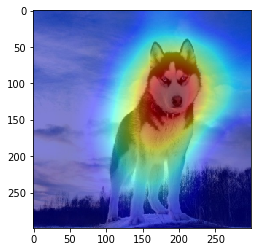

In [11]:
img_init=utils.load_img(im_file,target_size=(299,299))
plt.imshow(overlay(img_init, heatmap))
plt.show()

The red region represents the area of the image on which the network focuses. This result is very nice as main attention is given at the head of the dog.

### Custom Model :

We run the same process over the custom model trained for car crash detection.


The activation of the last FC layer is removed :

In [5]:
#With Custom Model

# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(model, 'dense_2')
print("Remove Activation from Last Layer")
# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear
print("Done. Now Applying changes to the model ...")
model = utils.apply_modifications(model)

Remove Activation from Last Layer
Done. Now Applying changes to the model ...


/Users/edwarddebrouwer/ENV/lib/python2.7/site-packages/keras/models.py:258: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


We import images from our test-set and compute the activation heatmap for the picture.

/Users/edwarddebrouwer/ENV/lib/python2.7/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


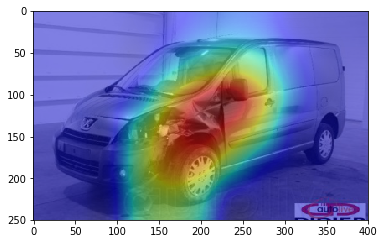

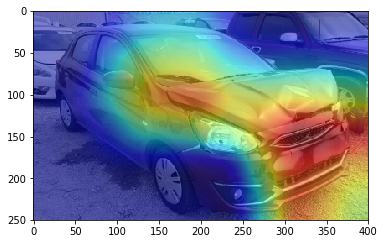

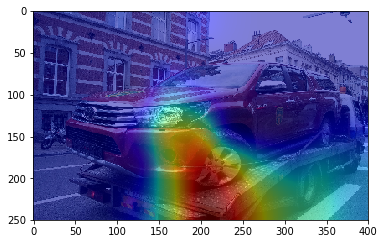

In [6]:
#Path to test images.
im_files=["../PICS/test_full/Damaged/D477.jpg","../PICS/val_full/Damaged/DD73.jpg","./own_car.jpg"]
for im_file in im_files:
    img1 = image.load_img(im_file,target_size=(250,400))
    img1 = image.img_to_array(img1)
    img1 = np.expand_dims(img1, axis=0)
    img1 = preprocess_input(img1)
    layer_idx = utils.find_layer_idx(model, 'dense_2')
    heatmap = visualize_cam(model, layer_idx, filter_indices=0, seed_input=img1[0,:,:,:])
    img_init=utils.load_img(im_file,target_size=(250,400))
    plt.imshow(overlay(img_init, heatmap))
    plt.show()

Here again, we obtain a very nice result, the network focuses on the damaged part of the cars. The last picture is a picture I took with my phone. The dataset did not contain any cars on tow-trucks but the network is still able to figure out the damaged part.

## Vizualisation of the Early Filters in the Network.

To visualize the filters in the network, we compute the input-image that maximizes the output of the specific filter we want to study. We have to specify the layer index and the filter number. 

This maximization is performed using gradient ascent. By default, 20 steps are considered for the optimization process.

We first plot the resulting images for the first filters. We focus on the first convolutional layer and pick 3 filters among the 32 present in this layer.

The first layers basically focus on colours as shown below :

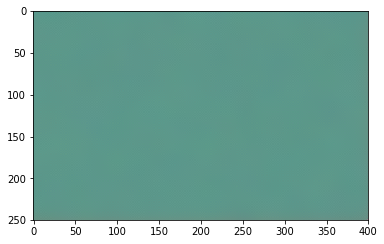

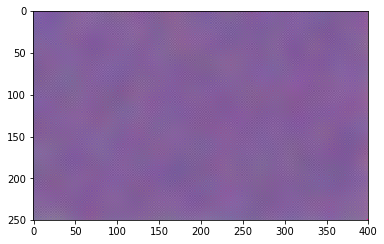

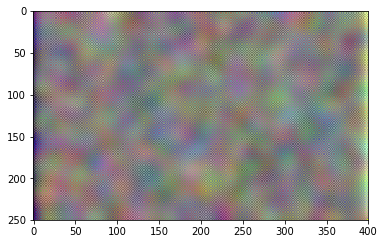

In [15]:
#First Layer Filters (3 among the 32)
layer_name="conv2d_1" #first conv layer
layer_idx = utils.find_layer_idx(model, layer_name)

for filter_idx in [0,10,20]:
    visu=visualize_activation(model,layer_idx,filter_indices=filter_idx)
    plt.imshow(visu)
    plt.show()

Let's now examine filters from upper layers :

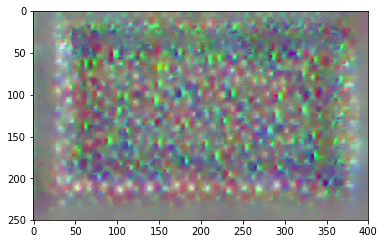

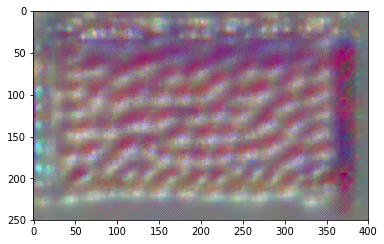

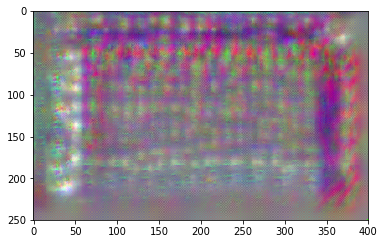

In [17]:
#Middle Layers Filters (3 among the 96)
layer_name="conv2d_30" #first conv layer
layer_idx = utils.find_layer_idx(model, layer_name)

for filter_idx in [10,30]:
    visu=visualize_activation(model,layer_idx,filter_indices=filter_idx)
    plt.imshow(visu)
    plt.show()

We see that the deeper we dive into the network, the more complex the filters. Below, we plot 2 other deeper filters activation.

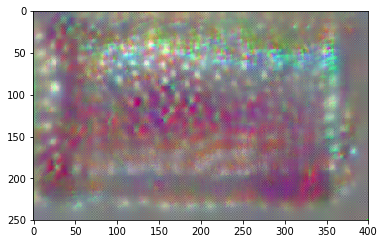

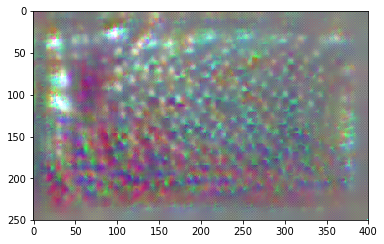

In [18]:
#Middle Layers Filters (2 among the 192)
layer_name="conv2d_73" #first conv layer
layer_idx = utils.find_layer_idx(model, layer_name)

for filter_idx in [63,172]:
    visu=visualize_activation(model,layer_idx,filter_indices=filter_idx)
    plt.imshow(visu)
    plt.show()

The reader may choose to plot other filters based on the list of layers of the model that is displayed below :